In [1]:
import os
import time
import cv2

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
%matplotlib inline

from typing import Union

from PIL import Image

from ultralytics import YOLO
from ultralytics.engine.results import Results

### Display section

In [2]:
def display_training(training_data: pd.core.frame.DataFrame)-> None:
    """loss and precision curve display 

    Args:
        training_data (pd.core.frame.DataFrame): training data 
    """
    train_loss = np.array(training_data.iloc[:, 2])
    val_loss = np.array(training_data.iloc[:, 14])

    mask_precision = np.array(training_data.iloc[:, 9])

    fig, axs = plt.subplots(1,2, figsize=(15,6))

    
    
    axs[0].plot(train_loss, label='train_loss')
    axs[0].plot(val_loss, label='val_loss')
    axs[0].set_xlabel('epochs')
    axs[0].set_title("Loss")
    axs[0].legend()

    axs[1].plot(mask_precision)
    axs[1].set_xlabel('epochs')
    axs[1].set_title("Mask precision")
    plt.show()

In [3]:
def display_confusion_matrix(confusion_matrix: np.array) -> None:
    """confusion matrix display

    Args:
        confusion_matrix (np.array): confusion matrix
    """
    total = np.sum(confusion_matrix)

    plt.figure(figsize=(8,6))

    # Ajouter la matrice de confusion au graphique
    plt.imshow(confusion_matrix, cmap=plt.cm.Blues)
    
    # Ajouter des étiquettes aux axes x et y
    plt.xlabel("Prédiction")
    plt.ylabel("Vérité")
    
    classes = ["Classe 0", "Classe 1"]
    plt.xticks([0, 1], classes)
    plt.yticks([0, 1], classes)
    
    # Ajouter les nombres de la matrice de confusion
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, f'{confusion_matrix[i, j]},\n ({round(confusion_matrix[i, j]/total*100,2)}) %'
                     , ha="center", va="center", color="white")
    
    plt.title("Matrice de confusion")
    plt.show()

### IoU section

In [4]:
def get_all_mask_image(result: Results) -> np.ndarray:
    """returns the full predicted mask

    Args:
        result (Results): masks predicts

    Returns:
        np.ndarray: full mask predicts
    """
    masks = result.masks.data
    image = np.zeros((512, 512), dtype=np.uint8)
    for mask in masks:
        mask = mask.cpu().numpy() * 255
        mask = mask.astype(np.uint8)
        image += mask
    return image

In [5]:
def get_mask_image(result: Results) -> np.ndarray:
    """returns the centered predicted mask

    Args:
        result (Results): masks predicts

    Returns:
        np.ndarray: centered mask
    """
    try:
        masks = result.masks.data
    except AttributeError:
        print('erreur')
        return []
        
    image = np.zeros((512, 512), dtype=np.uint8)
    masks_return = []

    for mask in masks:
        mask = mask.cpu().numpy() * 255
        mask = mask.astype(np.uint8)
        if mask[254,254] == 255:
            masks_return.append(mask)
            
    return masks_return

In [6]:
def get_all_mask_label(i: int) -> np.ndarray:
    """returns the full labelled mask

    Args:
        i (int): label number 

    Returns:
        np.ndarray: full label mask
    """
    file = open(f'../data/labels/test/image_{i}.txt', "r")
    lines = file.readlines()
    
    # Créer une image vide de taille 512x512 pixels
    label = np.zeros((512, 512), dtype=np.uint8)
    
    coord = []
    # Parcourir les lignes du fichier texte
    for line in lines:
    
        sommets = (np.array(line.split()[1:], dtype=float)*512).astype(int)
        sommets = sommets.reshape(-1,2)
    
        cv2.fillPoly(label, pts=[sommets], color=(255, 255, 255))
    return label

In [7]:
def get_mask_label(i: int) -> np.ndarray:
    """returns the full centered mask

    Args:
        i (int): label number 

    Returns:
        np.ndarray: centered label mask
    """
    file = open(f'../data/labels/test/image_{i}.txt', "r")
    lines = file.readlines()
    
    # Créer une image vide de taille 512x512 pixels
    label = np.zeros((512, 512), dtype=np.uint8)
    
    coord = []
    # Parcourir les lignes du fichier texte
    for line in lines:
        temp = np.zeros((512, 512), dtype=np.uint8)
        sommets = (np.array(line.split()[1:], dtype=float)*512).astype(int)
        sommets = sommets.reshape(-1,2)

        cv2.fillPoly(temp, pts=[sommets], color=(255, 255, 255))

        if temp[254,254] == 255:
            cv2.fillPoly(label, pts=[sommets], color=(255, 255, 255))
            
    return label

In [8]:
def rapport_parcelles(results: list, nb_image: int, all_masks: bool) -> Union[np.ndarray, np.ndarray]: 
    """recovery of all masks

    Args:
        results (list): predictions
        nb_image (int): image number 
        all_masks (bool): all mask or only the centered mask

    Returns:
        Union[np.ndarray, np.ndarray]: images masks, labels masks
    """
    numbers = np.arange(nb_image)
    sorted_numbers = sorted(numbers, key=str)

    images = []
    labels = []
    if all_masks:
        for image_order, label_order in enumerate(sorted_numbers):
            #print(f'{image_order}, {label_order}')
            images.append(get_all_mask_image(results[image_order]))
            labels.append(get_all_mask_label(int(label_order)))
    else : 
        for image_order, label_order in enumerate(sorted_numbers):
            #print(f'{image_order}, {label_order}')
            images.append(get_mask_image(results[image_order]))
            labels.append(get_mask_label(int(label_order)))

    return images, labels

In [9]:
def calculate_iou(images: np.ndarray, labels: np.ndarray) -> float:
    """
    Calculate Intersection over Union (IoU) for all pair of predicted and ground truth masks.

    Args:
        images (np.ndarray): Predicted segmentation masks.
        labels (np.ndarray): Ground truth segmentation masks.

    Returns:
        float: Mean IoU score.
    """
    Mean_IoU = []
    for i, (image,label) in enumerate(zip(images,labels)):
        
        try : 
            intersection = np.logical_and(image, label).sum()
            union = np.logical_or(image, label).sum()
            iou = intersection / union if union != 0 else 0
            Mean_IoU.append(float(iou))
        except ValueError:
            pass

    return np.mean(Mean_IoU)

In [12]:
def __main__():
    #to_modify
    #chemin d'acces vers les différents fichiers necessaires
    directory = "runs/segment/train_crop/"
    test_dataset_path = "../data/images/test"
    yaml_path = "yaml/yolo_sat.yaml"

    #to_modify
    #IoU avec tous les masks
    all_masks = False

    #chargement des données
    model = YOLO(f"{directory}weights/best.pt")
    training_data = pd.read_csv(f"{directory}results.csv")
    results = model(test_dataset_path, verbose=False)
    metrics = model.val(data=yaml_path)
    
    #affichage
    display_training(training_data)
    display_confusion_matrix(metrics.confusion_matrix.matrix)

    #IoU
    images, labels = rapport_parcelles(results, 349, all_masks)
    Mean_IoU = calculate_iou(images,labels)
    print(f' IoU Moyen sur le dataset de test est de : {Mean_IoU}')

Ultralytics YOLOv8.2.28 🚀 Python-3.9.18 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 4070, 12009MiB)


val: Scanning /tf/StageLeandre/YOLO/data/labels/val.cache... 393 images, 0 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.20it/s]


                   all        393       9588      0.656      0.608       0.64      0.447      0.645      0.577      0.601      0.373
Speed: 0.2ms preprocess, 8.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/segment/val3


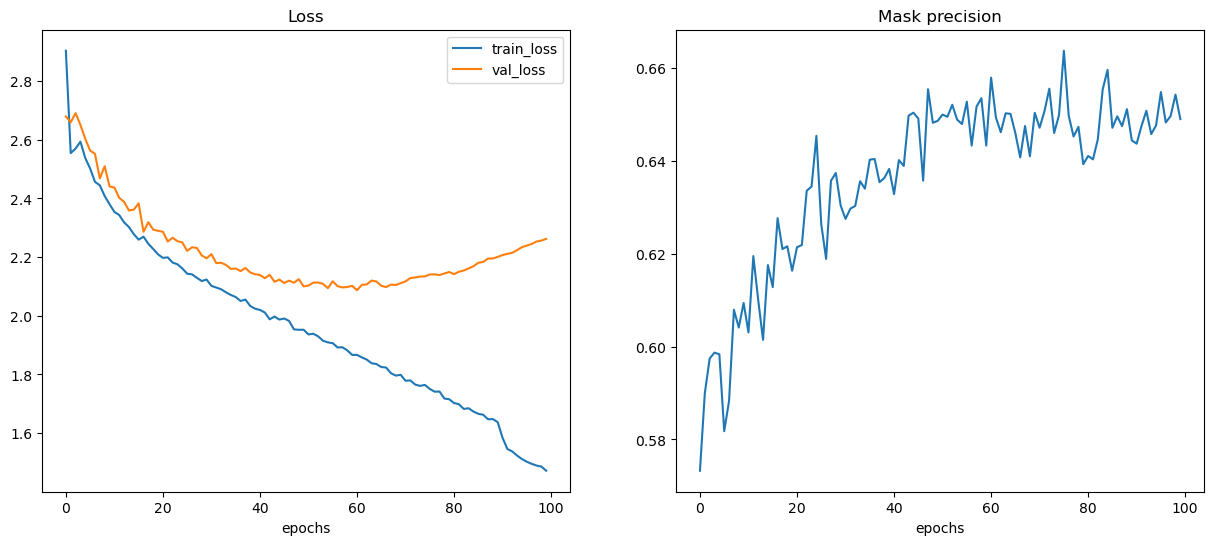

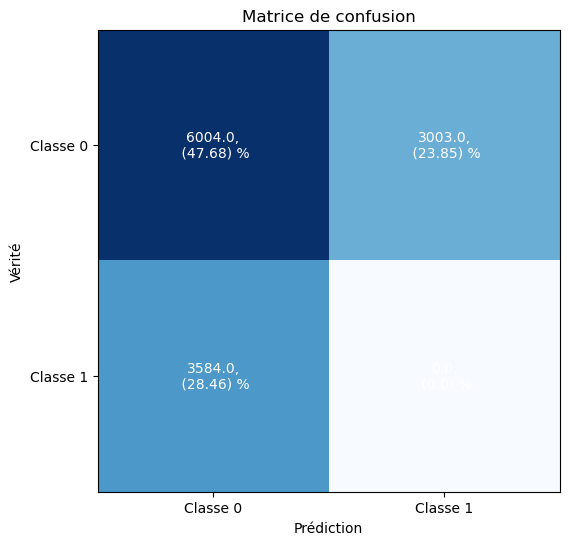

 IoU Moyen sur le dataset de test est de : 0.6209331819278383


In [13]:
__main__()

$$\begin{aligned}
& \text {Table 1.1. Metrics }\\
&\begin{array}{cccc}
\hline \hline  & \text { Precision } & \text { Recall } & \text { mAP50 } & \text { mAP50-95 } \\
\hline \text {Detection  d'objet} & 0.656 & 0.608 & 0.64 & 0.447 \\
\text {Segmentation} & 0.645 & 0.577 & 0.601 & 0.373 \\
\\
\hline
\end{array}
\end{aligned}$$



Precision: La précision des objets détectés, indiquant combien de détections étaient correctes.

Recall: La capacité du modèle à identifier toutes les instances d'objets dans les images.

mAP50: précision moyenne calculée à un seuil d'intersection sur union (IoU) de 0,50. C'est une mesure de la précision du modèle qui ne prend en compte que les détections "faciles".

mAP50-95: La moyenne de la précision moyenne calculée à différents seuils d'IoU, allant de 0,50 à 0,95. Elle donne une vue d'ensemble des performances du modèle à différents niveaux de difficulté de détection.
